# Capstone 2: Heart Disease - Preprocessing, Training Data, and Modeling

## Imports 

In [23]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    #plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Load Data

In [24]:
heart = pd.read_csv('./Data/Heart.csv')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Logistic Regression 

<AxesSubplot:xlabel='chol', ylabel='trestbps'>

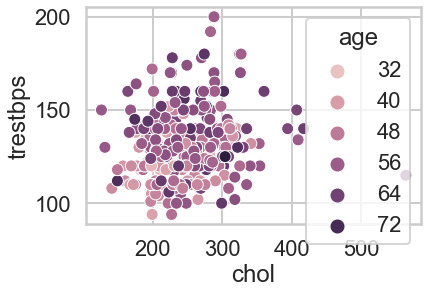

In [25]:
sns.scatterplot(data = heart , x='chol',y='trestbps', hue = 'age')

In [26]:
# Splitted data into a training and test set

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

Xlr, Xtestlr, ylr, ytestlr = train_test_split(heart[['age','chol']].values, 
                                              (heart.age == 40).values,random_state=5)

clf = LogisticRegression()

clf.fit(Xlr, ylr)
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.9868421052631579


In [27]:
#KFold

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 6
    for train, test in KFold(nfold).split(x): # split data into train/test groups
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test])
    return result / nfold # average

In [28]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9868421052631579


In [29]:
Cs = [0.001, 0.1, 1, 10, 100]

list=[]

for i in Cs:
    clf = LogisticRegression(C=i)
    score = cv_score(clf, Xlr, ylr)
    list.append(score)
    
print(list)

[0.9912280701754387, 0.9912280701754387, 0.9868421052631579, 0.9868421052631579, 0.9868421052631579]


In [30]:
clf = LogisticRegression(C=0.1)
clf.fit(Xlr,ylr)
accuracy_score(clf.predict(Xtestlr),ytestlr)

0.9868421052631579

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': Cs}
clf = LogisticRegression()
clf_cv = GridSearchCV(clf, param_grid, cv=5)
clf_cv.fit(Xlr, ylr)

print(clf_cv.best_params_)
print(clf_cv.best_score_)

/Users/aakash/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


{'C': 0.001}
0.9913043478260869


In the logistic regression, we see that all of our scores vary around .98. With the Cross valiadation score high, we see that the overall proabability of heart deseiase being present in very accurate of it's features.  

## Decision Tree 

In [33]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

In [34]:
#NP = NoPrediction 
NP = heart.dropna()
NP['target'].describe()

count    303.000000
mean       0.544554
std        0.498835
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

<AxesSubplot:xlabel='target', ylabel='age'>

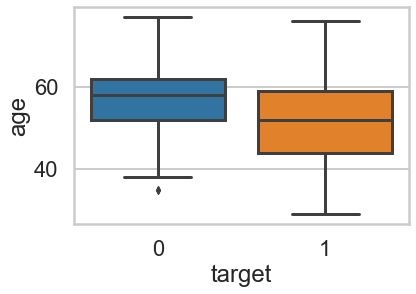

In [35]:
sns.boxplot(data=NP, y="age", x= "target")

<AxesSubplot:xlabel='chol', ylabel='age'>

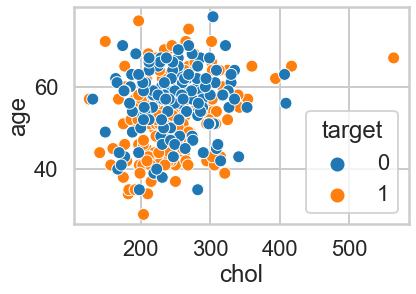

In [36]:
sns.scatterplot(data =NP, y="age", x= "chol", hue = "target")

Shown above in the boxplot above, we see that the median in age and taget is very similar resulting an oput of 1 (heart deseasise being postiive).
Our scatterplot illistrates the level of cholestoral level by age (0, no heart desiease present, 1, present. This chart made to understand the correlation of hihg or low cholestrol levels and age. 

In [37]:
Prediction = heart[pd.isnull(heart['target'])]
Prediction.head()
Prediction.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
heart.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'], dtype='object')

In [39]:
NP.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'], dtype='object')

In [40]:
split1 = heart[['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']]
split2 = heart[['target']]

In [41]:
X = split1
y = split2

In [42]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.25, random_state = 246)

In [43]:
from sklearn import tree, metrics

entr_model = tree.DecisionTreeClassifier(criterion= "entropy", random_state = 20)
entr_model.fit(X_train, y_train)
y_pred = entr_model.predict(X_test)
y_pred = pd.Series(y_pred)
entr_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=20, splitter='best')

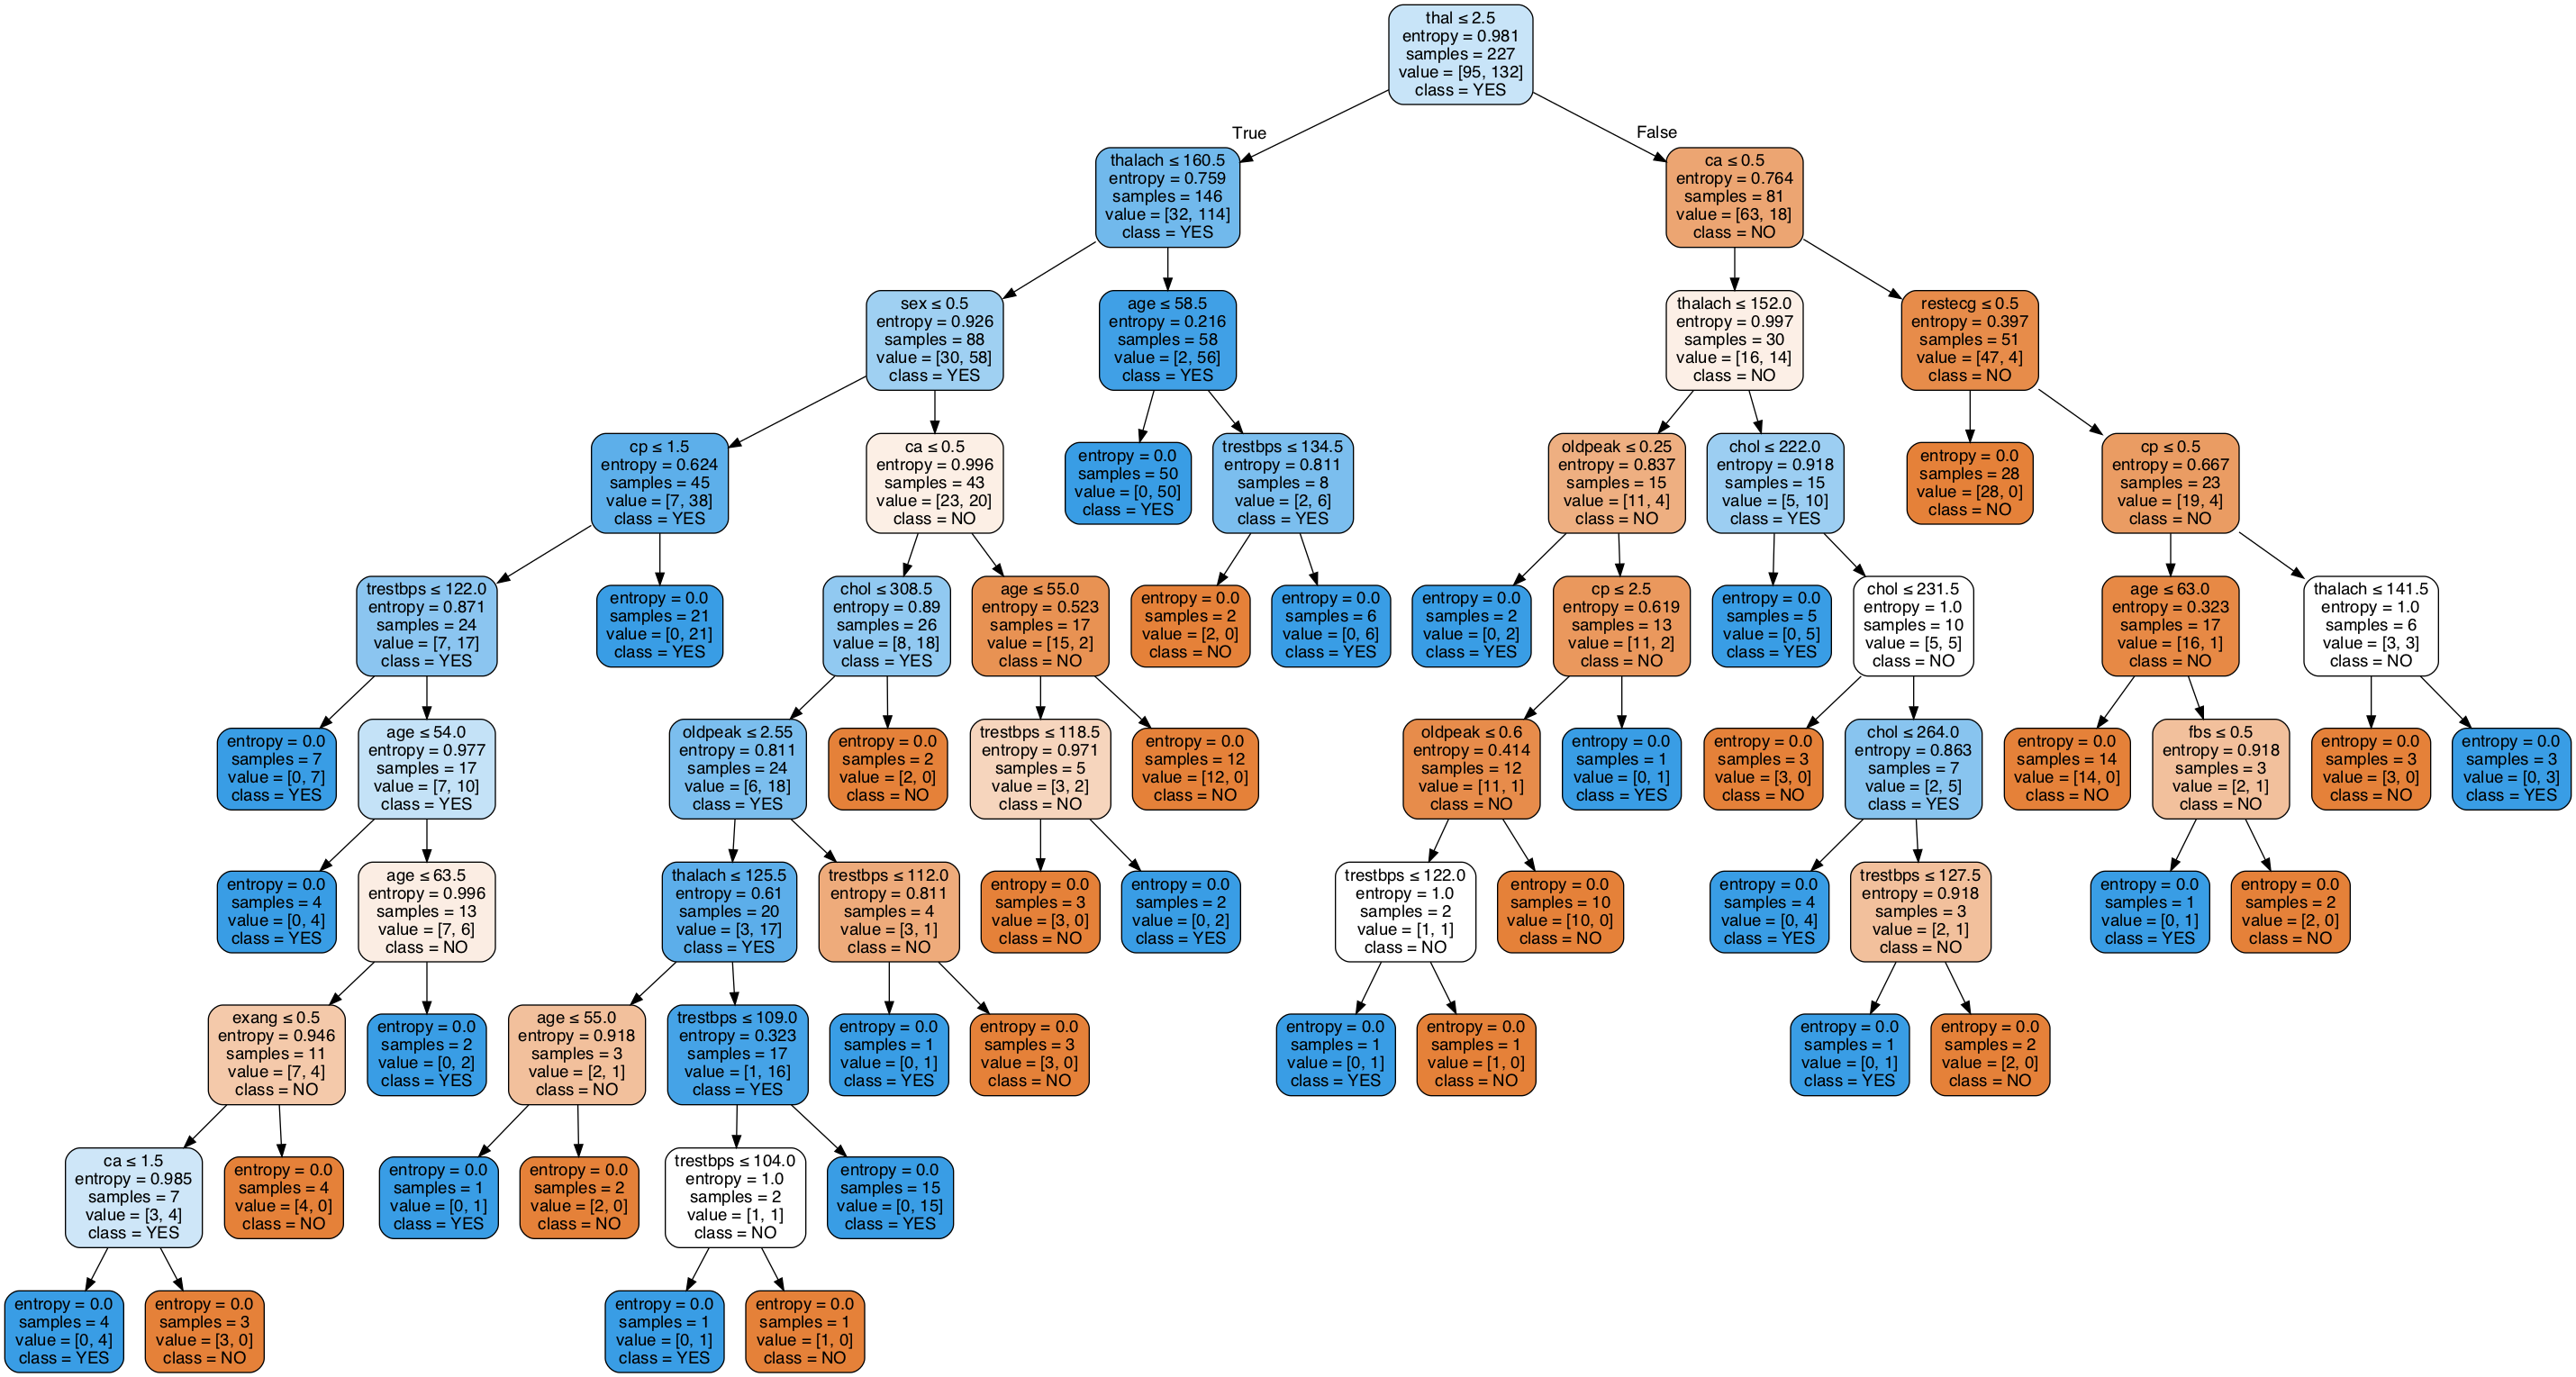

In [45]:
dot_data = StringIO()
tree.export_graphviz(entr_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"]) 

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Model 1:  Entropy model - No Max

In [46]:
print("Model Entropy - no max depth")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score:' , metrics.precision_score(y_test,y_pred))
print('Recall score:' , metrics.recall_score(y_test,y_pred))


Model Entropy - no max depth
Accuracy: 0.75
Balanced accuracy: 0.7614517265680056
Precision score: 0.6666666666666666
Recall score: 0.8484848484848485


We can here that when applying the split model, we are only getting third of the accuracy. comaped to the logistic regression, our results were much higher and closer to 100 score accuracy. Here we see that we have a moderetly high entropy level of disorder(low level of purity). Using the 76 accuracy score, we can state that the level of uncertinity is high. 

### Model 2:  Gini model - No Max

In [47]:
gini_model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 37)
gini_model.fit(X_train, y_train)
gini_model.predict(X_test)
y_pred = pd.Series(y_pred)

gini_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=37, splitter='best')

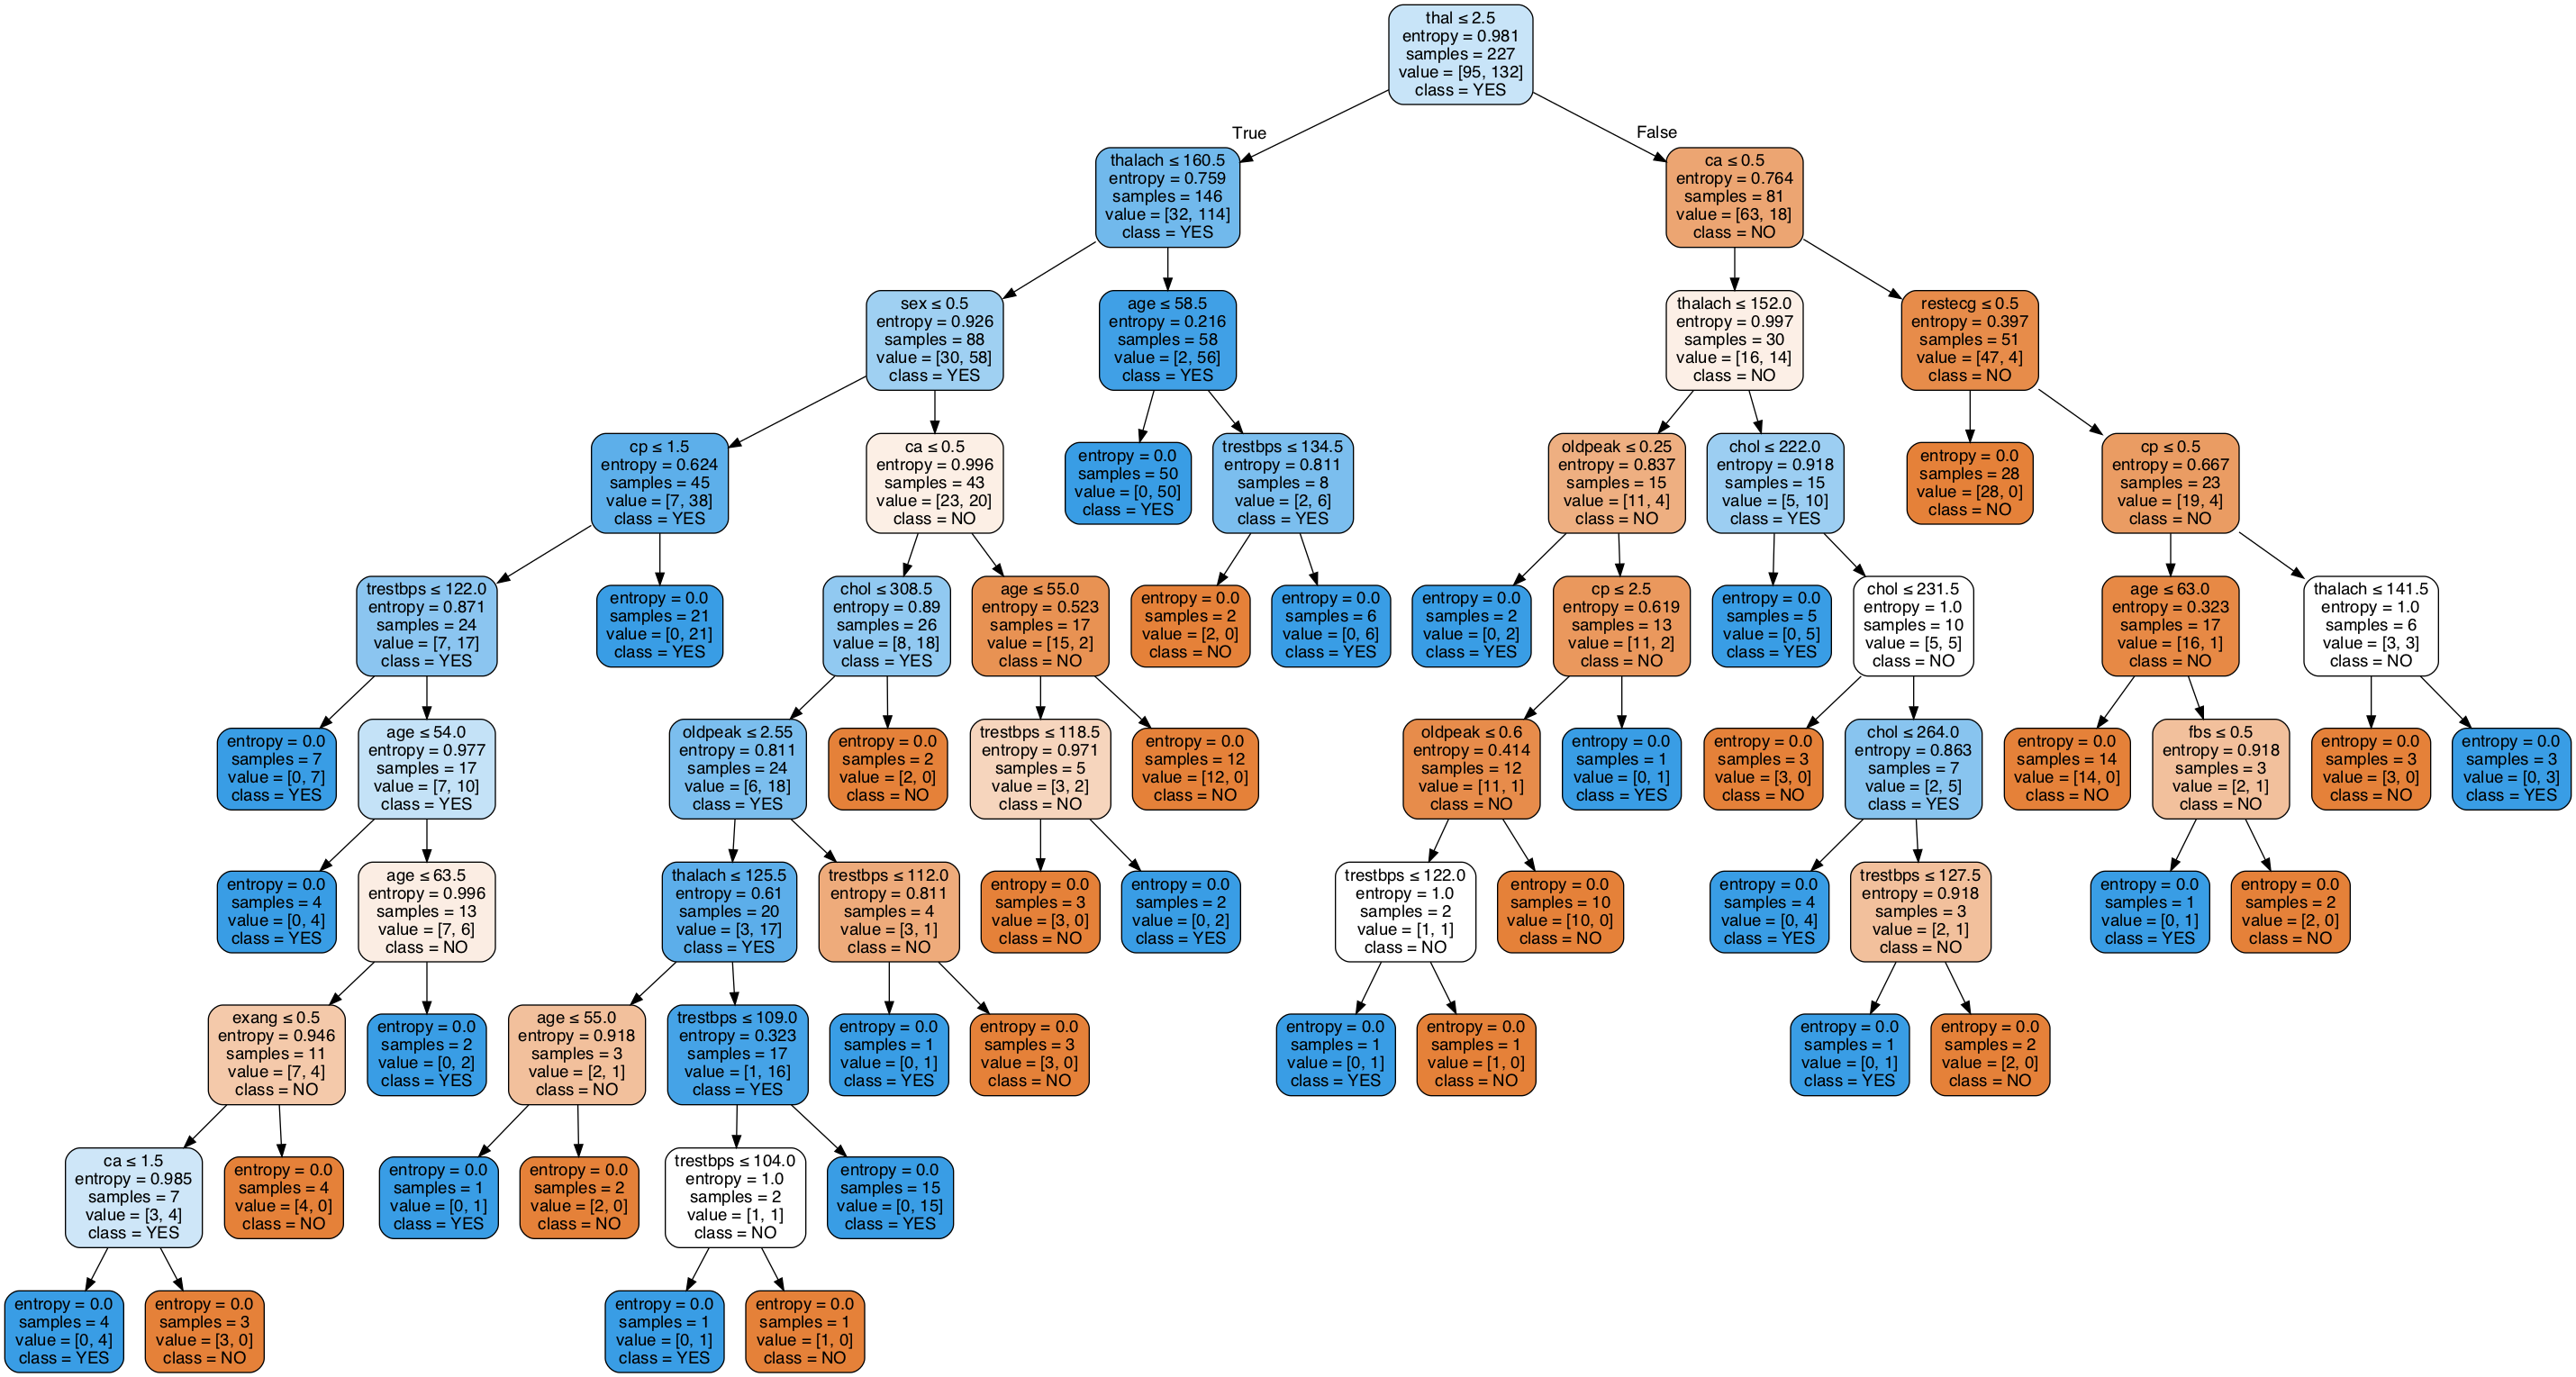

In [73]:
# As before, but make the model name gini_model
dot_data = StringIO()
tree.export_graphviz(entr_model , out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"])

# Alternatively for class_names use gini_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# Alternatively for class_names use gini_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [49]:
print("Model Gini impurity model")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score:' , metrics.precision_score(y_test,y_pred))
print('Recall score:' , metrics.recall_score(y_test,y_pred))

Model Gini impurity model
Accuracy: 0.75
Balanced accuracy: 0.7614517265680056
Precision score: 0.6666666666666666
Recall score: 0.8484848484848485


Here we can see that the results are super similar to our entropy model 1. With understanding that the Gini model is measured between 0 and 1, we can see that the the model is good as it is closer to 1. 

### Model 3: Entropy model

In [50]:
entr_model2 = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 3, random_state = 1234)
entr_model2.fit(X_train, y_train)
y_pred = entr_model2.predict(X_test)
y_pred = pd.Series(y_pred)
entr_model2

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

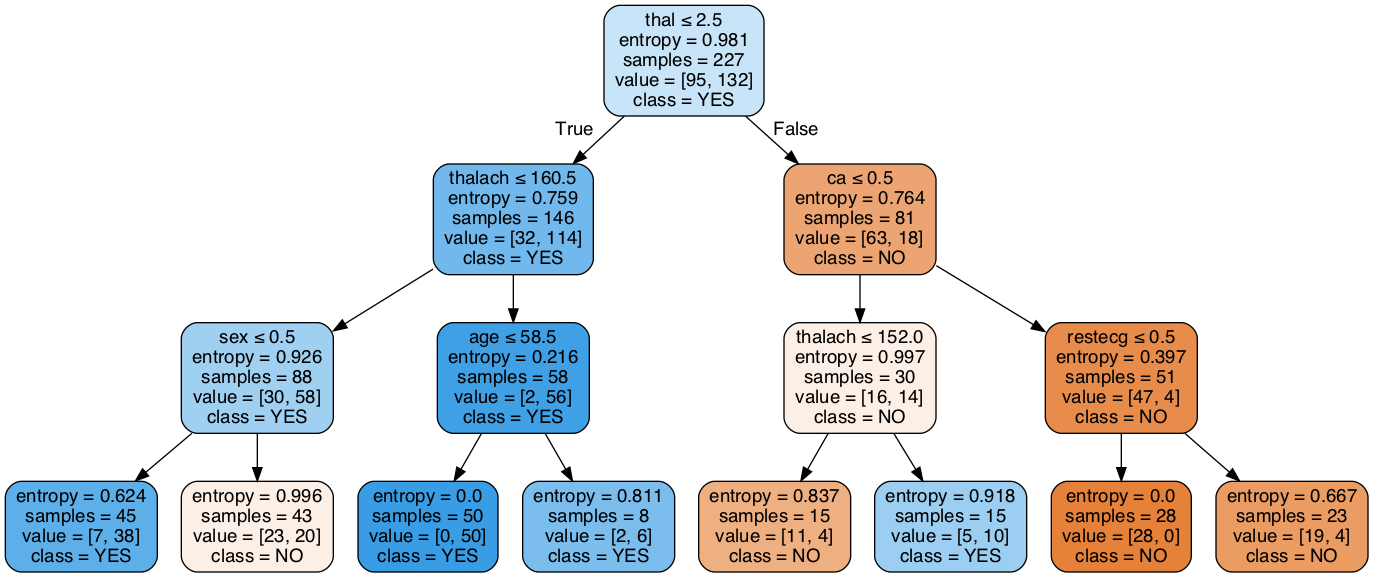

In [51]:
dot_data = StringIO()
tree.export_graphviz(entr_model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"])

# Alternatively for class_names use entr_model2.classes_
entr_model2.classes_ = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(entr_model2.classes_.create_png())

In [52]:
print("Model Entropy model max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test,y_pred))
print('Recall score for "No"' , metrics.recall_score(y_test,y_pred))

Model Entropy model max depth 3
Accuracy: 0.7368421052631579
Balanced accuracy: 0.7357293868921776
Precision score for "Yes" 0.6857142857142857
Recall score for "No" 0.7272727272727273


We see here in model three that the accuracy and presision score has decreased. With the cost of error high on the data, a random cross validation was used and applied to understand and find the correct deepth of the tree. 

### Model 4: Gini impurity model 

In [53]:
from sklearn.ensemble import GradientBoostingClassifier

gini_model2 = tree.DecisionTreeClassifier(criterion='gini', random_state= 1234, max_depth = 3)

# Do the fit, predict, and series transformations as before. 
gini_model2.fit(X_train, y_train)
y_pred = gini_model2.predict(X_test)
y_pred = pd.Series(y_pred)
gini_model2

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

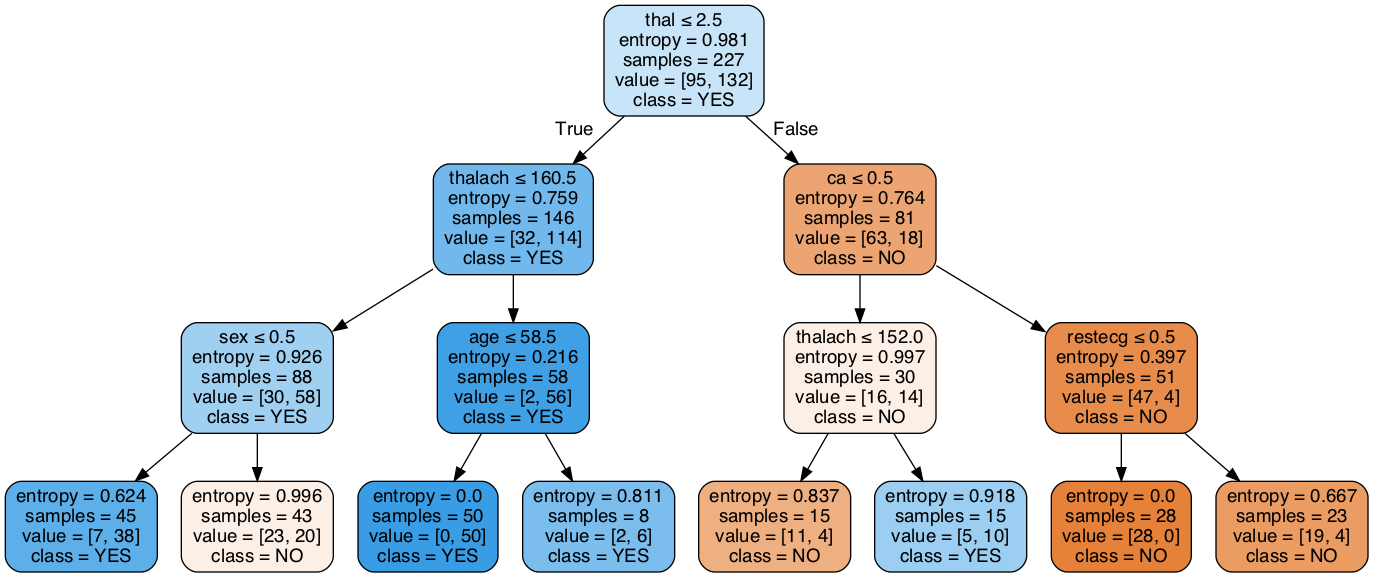

In [54]:
dot_data = StringIO()
tree.export_graphviz(entr_model2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ["NO", "YES"])


# Alternatively for class_names use gini_model2.classes_
gini_model2.classes_ = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(gini_model2.classes_.create_png())

In [55]:
print("Gini impurity  model - max depth 3")
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score' , metrics.precision_score(y_test,y_pred))
print('Recall score' , metrics.recall_score(y_test,y_pred))

Gini impurity  model - max depth 3
Accuracy: 0.7236842105263158
Balanced accuracy: 0.7417195207892882
Precision score 0.6304347826086957
Recall score 0.8787878787878788


Our last model in decision tress looks pretty accurate in terms of the presision and accuracy score, althogu hthe score may not be at it's highest. 

## Gradiant Boosting

In [56]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [57]:
split1 = heart[['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']]
split2 = heart[['target']]

In [58]:
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier

X = split1
y = heart['target'].values

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25)

In [62]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gradiant = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gradiant.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gradiant.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gradiant.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.855
Accuracy score (validation): 0.882

Learning rate:  0.1
Accuracy score (training): 0.872
Accuracy score (validation): 0.895

Learning rate:  0.25
Accuracy score (training): 0.885
Accuracy score (validation): 0.855

Learning rate:  0.5
Accuracy score (training): 0.912
Accuracy score (validation): 0.816

Learning rate:  0.75
Accuracy score (training): 0.934
Accuracy score (validation): 0.829

Learning rate:  1
Accuracy score (training): 0.943
Accuracy score (validation): 0.816



Looking at the very first learning rate of .05, we can conclude that the the overall odds are very good, as the accuracy validation is faily high ata score of .882. When looking at the learning rate of 1, the training rate score of .943 we see that not much was shrunk. 

In [63]:
gradiant = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 2, random_state = 0)
gradiant.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
y_pred = gradiant.fit(X_test, y_test)
print(y_pred)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=20,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


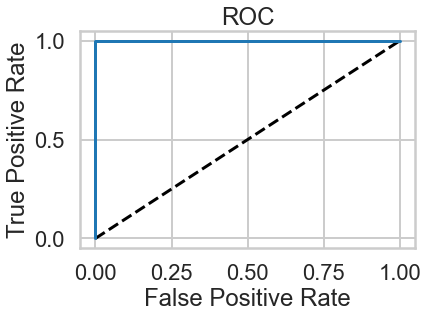

In [65]:
from sklearn.metrics import roc_curve

y_pred_prob = gradiant.predict_proba(X_test)[:,1]
fpr, tpr, tresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label ='Logistic Regression')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

This chart shows that we hace a differnet corrleation in the classification model, as it is at 1. 

## Random Forest

<AxesSubplot:>

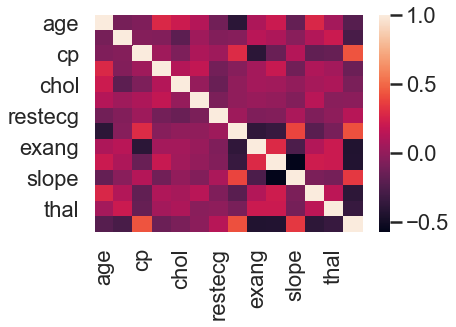

In [66]:
sns.heatmap(heart.corr())

<AxesSubplot:>

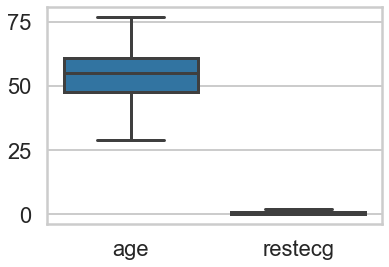

In [67]:
# Outlier 1 
sns.boxplot(data = heart[['age','restecg']])

<AxesSubplot:>

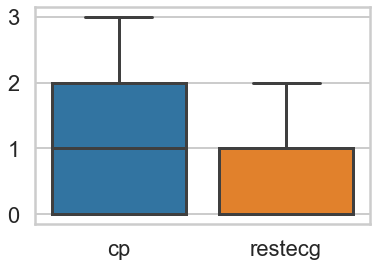

In [68]:
# Outlier 2
sns.boxplot(data = heart[['cp','restecg']])

<AxesSubplot:>

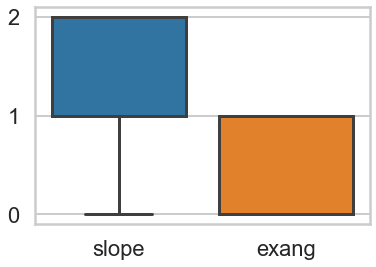

In [69]:
# Outlier 3
sns.boxplot(data = heart[['slope','exang']])

With many overlaying outliers seen in the heatmap, we dive deep into three boxplots: age and restecg, cp, and restecg, in addition to slope and exang. 
With high and low similaritiers in the mean, the proabability of a higher age may result in low restecg (maximum heart rate achieved). Outlier 2 demonstrates 
with an average cp, the restecg is half. Lastly, in outlier 3, with a slope of two, we have an incredibly low exang. 


#### Split the data into test and train subsamples

In [70]:
from sklearn.model_selection import train_test_split

X = split1
y = split2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [71]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=300, random_state = 1, n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Random Forest: Accuracy=%.3f" % (ac))
print("Random Forest: f1-score=%.3f" % (f1))

/Users/aakash/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random Forest: Accuracy=0.787
Random Forest: f1-score=0.785


According to the Random Forest model, we can see that the overall accuracy for the dataset is 78%. This showing that we have a lower weightage on the model, in addition to understanding that the accuracy of the dataset is not quite completed.